In [56]:
from cytoflow import *
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as st
import math

mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
plt.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['pdf.fonttype'] = 42
sns.set_style("ticks", { "xtick.major.size": 4, "ytick.major.size": 4, "font_color":'k', 'axes.edgecolor': 'k', 'xtick.color': 'k', 'ytick.color': 'k'})
sns.set_context("talk", font_scale=1.0)

# Loading Tubes

## Defining the tube-loading function

Copy this for future reference

In [43]:
plasmid_dict = { # maps plasmid number => plasmid name
#     57 : "ZIK1 KRAB + ZNF10 KRAB",    58 : "ZIK1 KRAB + FOXO3 TAD",
    59 : "ZIK1 KRAB + Rand Ctrl 89",  #60 : "KMT2C Dual + ZNF10 KRAB",
    61 : "KMT2C Dual + FOXO3 TAD",    #62 : "KMT2C Dual + Rand Ctrl 89",
    63 : "KMT2D Dual + ZNF10 KRAB",   #64 : "KMT2D Dual + FOXO3 TAD",
    65 : "KMT2D Dual + Rand Ctrl 89", 66 : "NCOA1 Dual + ZNF10 KRAB",
    67 : "NCOA1 Dual + FOXO3 TAD",    68 : "NCOA1 Dual + Rand Ctrl 89",
    69 : "NCOA2 Rep + FOXO3 TAD",     #70 : "Rand Ctrl + NCOA2 Act",
    #71 : "NCOA2 Rep + NCOA2 Act",     
    72 : "Rand Ctrl + Rand Ctrl 89",
    
    74 : "DMD - DMD",     75 : "DMD - RANDCTRL",      76 : "ZNF10 - ANM2",
    77 : "ZNF10 - CBX1",  78 : "RANDCTRL - RANDCTRL", 79 : "ANM2 - KIBRA",
    80 : "BIN1 - FOXO3",  81 : "CACO1 - ANM2",        82 : "CREM - MPP8",
    83 : "DPF1 - HSF2",   84 : "DPY30 - HXA13",       #85 : "FOXO3 - ZNF10",
    #86 : "IKKA - ANM2",   
    87 : "MPP8 - ZNF791", #88 : "MYBA - FOXO3",
    #89 : "NCOA2 - HXA13", 
    90 : "NOTC2 - ANM2",        91 : "NOTC2 - KIBRA",
    92 : "SMCA2 - U2AF4", 93 : "SUMO3 - SSX2",        94 : "YAF2 - ZNF791",
    #95 : "HES2 - NCOA2",  
    96 : "ATRX - HERC2",        97 : "SCML2 - NOTC2",
    98 : "CHD4 - CDYL2",  99 : "SMN2 - FOXO3",       
    
    126 : "rTetR only",  217 : "KRAB only",          144 : "MYBA only"
}

plasmid_numbers = sorted(list(plasmid_dict.keys()))
plasmid_names = [plasmid_dict[p] for p in plasmid_numbers]

In [44]:
days = [0, 1, 2]
treatments = ["none", "DMSO", "9-c-RA"]
dox_doses = [0, 1000]
replicates = [1, 2]

In [48]:
letters = ["A", "B", "C", "D", "E", "F", "G", "H"]
numbers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

def get_treatment_list(plasmid):
    if plasmid in [66, 67, 68, 69]:
        return ["DMSO", "9-c-RA"]
    if plasmid in [126, 217]:
        return ["none", "DMSO", "9-c-RA"]
    return ["none"]

def get_tube_location_d0(plasmid, treatment, replicate):
    layout = [
        [59, 61, 63, 64, 65, 66],
        [67, 68, 69, 70, 71, 72],
        [74, 75, 76, 77, 78, 79],
        [80, 81, 82, 83, 84, 87],
        [88, 89, 90, 91, 92, 93],
        [94, 95, 96, 97, 98, 99],
        [126, 217, 144]
    ]
    
    for row in layout:
        if plasmid in row:
            r = layout.index(row)
            c = row.index(plasmid) + 6 * (1-replicate)
            return letters[r] + str(numbers[c])

def get_tube_location(plasmid, treatment, replicate):
    treatment_row = [66, 67, 68, 69, 126, 217]
    if plasmid in treatment_row and treatment != "none":
        row = 1 if treatment == "DMSO" else 2
        col = 1 + treatment_row.index(plasmid) + 6 * (1 - replicate)
        return letters[row-1] + str(numbers[col-1])
    
    rows = [
        [59,  61,  63,  65],
        [72, 126, 217, 144],
        
        [74, 75, 76, 77, 78, 79],
        [80, 81, 82, 83, 84, 87],
        [90, 91, 92, 93, 94, 96],
        [97, 98, 99]
    ]
    four_one = [59, 61, 63, 65]
    four_two = [72, 126, 217, 144]
    
    for row in rows:
        if plasmid in row:
            r = letters[rows.index(row) + 2]
            c = row.index(plasmid) + 1 + 6 * (1-replicate)
            return r + str(numbers[c-1])

In [49]:
def get_tube_file(day, dox, plasmid, treatment, replicate):
    
    # first, get folder location
    filedir = './data'
    if day == 0:
        filedir = filedir + '/' + 'axm-20211111_allvall_validations_dy032_d0/axm-20211111_d0dox_dy032-20211111-1907'
    elif day == 1:
        if dox == 0:
            filedir = filedir + '/' + 'axm-20211112_d1_nodox_dy032-20211112-1743'
        else:
            filedir = filedir + '/' + 'axm-20211112_d1_dox_dy032-20211112-1708'
    else:
        if dox == 0:
            filedir = filedir + '/' + 'axm-20211113_d2_nodox_dy032-20211113-1901'
        else:
            filedir = filedir + '/' + 'axm-20211113_d2_dox_dy032-20211113-1944'
            
    tubename = get_tube_location_d0(plasmid, treatment, replicate) if day == 0\
                else get_tube_location(plasmid, treatment, replicate)
    
    return filedir + '/' + tubename + '.fcs'

## Here we go

In [51]:
tubeslist = []

for day in [0, 1, 2]:
    for dox in [0, 1000]:
        for plasmid in plasmid_dict:
            for treatment in get_treatment_list(plasmid):
                for replicate in [1, 2]:
                    #print(day, dox, plasmid, treatment, replicate)
                    tubeslist.extend([
                        Tube(conditions = {'plasmid' : plasmid,
                                           'description' : plasmid_dict[plasmid],
                                           'day' : day,
                                           'dox' : dox,
                                           'treatment' : treatment,
                                           'replicate' : replicate},
                            file = get_tube_file(day, dox, plasmid, treatment, replicate),
                            conditions_list = ['plasmid', 'description', 'day',
                                               'dox', 'treatment', 'replicate'])])

print("Loaded", len(tubeslist), "tubes")

Loaded 492 tubes


# Import

In [53]:
op0 = ImportOp(
    conditions = {
        'plasmid'     : 'category',
        'description' : 'category',
        'day'         : 'float',
        'dox'         : 'float',
        'treatment'   : 'category',
        'replicate'   : 'float'
    },
    tubes = tubeslist,
    channels={'mCitrine-A':'mCitrine-A',
              'mCherry-A':'mCherry-A',
              'FSC 488/10-A':'FSC 488/10-A',
              'SSC 488/10-A':'SSC 488/10-A'}
)

ex0 = op0.apply()

# Gate for live cells

CPU times: user 29.3 s, sys: 1.81 s, total: 31.1 s
Wall time: 13.7 s


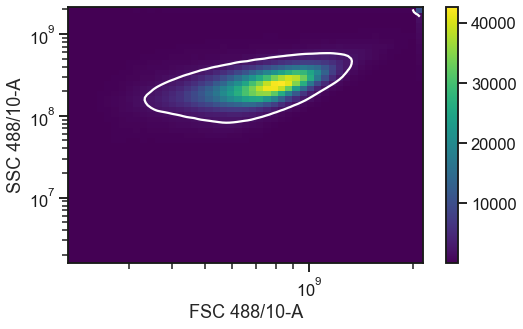

In [67]:
%%time

dens_op = DensityGateOp(
    name = 'P1',
    xchannel='FSC 488/10-A',
    xscale = 'log',
    ychannel='SSC 488/10-A',
    yscale = 'log',
    keep = 0.9)

dens_op.estimate(ex0)
ex1 = dens_op.apply(ex0)
dens_op.default_view().plot(ex0, height = 5)

In [68]:
ex1.data.groupby('P1').size()

P1
False     302660
True     2848679
dtype: int64

# Gate on mCherry

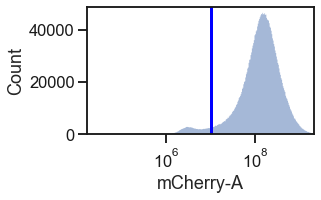

In [70]:
op_2 = ThresholdOp(
    name='mCherry', threshold=1e7, channel='mCherry-A')
ex_2 = op_2.apply(ex1)
op_2.default_view(
    subset='(P1==True)', scale='log').plot(ex_2)

# Export data

In [73]:
ex_2.data.to_csv('./data/all_cells_live_mch_gated.csv', index = False)